# 1.2 Modellierung des Strompreises von Österreich mittels linearer Regression


In dieser Aufgabe wird ein Regressionsmodell zur Abschätzung des stündlichen Strompreises in Österreich erstellt. Der Preis ist jeweils abhängig von der Netzlast (NL) und der Einspeisung erneuerbarer Energie (EE). Als erneuerbare Energieträger werden im Modell Wind, PV und Wasserkraft einbezogen. Die jeweiligen Nachfrage-und Erzeugungsdaten für Österreich im Jahr 2019 stammen von der ENTSO-E und wurden bereitgestellt. Es wurde das Jahr 2019 gewählt, da es sich im Jahr 2020 um ein coronabedingtes "Ausnahmejahr" mit einem Rückgang der Netzlast handelte. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from IPython.display import display, Latex
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,  mean_squared_error

In [2]:
notebook_path = Path("__file__").parent.resolve()
#print(notebook_path)

year = 2019
filename = f"AT_{year}.csv"
prices_path = notebook_path / "ENTSOE_countries" / "Prices"
#print(f"Prices path: {prices_path}")
file = prices_path / filename
#print(f"file: {file}")
df_prices = pd.read_csv(file)

demand_path = notebook_path / "ENTSOE_countries" / "Demand"
file = demand_path / filename
df_demand = pd.read_csv(file)

generation_path = notebook_path / "ENTSOE_countries" / "Generation"
file = generation_path / filename
df_generation = pd.read_csv(file)

In [3]:
df_demand_hourly = df_demand[df_demand.index % 4 == 0 ]
df_demand_hourly

,Time,Demand
0,2019-01-01T00:00:00.0,6139.0
4,2019-01-01T01:00:00.0,5976.0
8,2019-01-01T02:00:00.0,5764.0
12,2019-01-01T03:00:00.0,5406.0
16,2019-01-01T04:00:00.0,5274.0
...,...,...
35020,2019-12-31T19:00:00.0,7304.0
35024,2019-12-31T20:00:00.0,6878.0
35028,2019-12-31T21:00:00.0,6555.0
35032,2019-12-31T22:00:00.0,6562.0


In [4]:
df_generation_hourly = df_generation[df_generation.index % 4 == 0 ]
df_generation_hourly

,Time,Solar,WindOnShore,WindOffShore,Hydro,HydroStorage,HydroPumpedStorage,Marine,Nuclear,Geothermal,...,Waste,OtherRenewable,Lignite,Coal,Gas,CoalGas,Oil,ShaleOil,Peat,Other
0,2019-01-01T00:00:00.0,0.0,284.0,0.0,2712.0,139.0,-1577.0,0.0,0.0,0.0,...,100.0,0.0,0.0,154.0,1326.0,0.0,0.0,0.0,0.0,22.0
4,2019-01-01T01:00:00.0,0.0,200.0,0.0,2706.0,202.0,-1584.0,0.0,0.0,0.0,...,100.0,0.0,0.0,154.0,1045.0,0.0,0.0,0.0,0.0,22.0
8,2019-01-01T02:00:00.0,0.0,156.0,0.0,2752.0,124.0,-1397.0,0.0,0.0,0.0,...,100.0,0.0,0.0,155.0,648.0,0.0,0.0,0.0,0.0,22.0
12,2019-01-01T03:00:00.0,0.0,116.0,0.0,2767.0,84.0,-1610.0,0.0,0.0,0.0,...,100.0,0.0,0.0,155.0,574.0,0.0,0.0,0.0,0.0,22.0
16,2019-01-01T04:00:00.0,0.0,140.0,0.0,2754.0,93.0,-1620.0,0.0,0.0,0.0,...,100.0,0.0,0.0,154.0,457.0,0.0,0.0,0.0,0.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35020,2019-12-31T19:00:00.0,0.0,2108.0,0.0,2519.0,582.0,1687.0,0.0,0.0,0.0,...,100.0,0.0,0.0,163.0,1776.0,0.0,0.0,0.0,0.0,22.0
35024,2019-12-31T20:00:00.0,0.0,1900.0,0.0,2490.0,386.0,684.0,0.0,0.0,0.0,...,100.0,0.0,0.0,162.0,1825.0,0.0,0.0,0.0,0.0,22.0
35028,2019-12-31T21:00:00.0,0.0,1804.0,0.0,2396.0,250.0,412.0,0.0,0.0,0.0,...,100.0,0.0,0.0,163.0,1840.0,0.0,0.0,0.0,0.0,22.0
35032,2019-12-31T22:00:00.0,0.0,2076.0,0.0,2358.0,120.0,166.0,0.0,0.0,0.0,...,100.0,0.0,0.0,163.0,1730.0,0.0,0.0,0.0,0.0,22.0


In [5]:
demand = df_demand_hourly.loc[:, "Demand"].to_numpy()
prices = df_prices.loc[:, "Price"].to_numpy()
df_generation_sum = df_generation_hourly["Solar"] + df_generation_hourly["WindOnShore"] + df_generation_hourly["Hydro"]
generation_solar = df_generation_hourly.loc[:, "Solar"].to_numpy()
generation_wind_on_shore = df_generation_hourly.loc[:, "WindOnShore"].to_numpy()
generation_hydro = df_generation_hourly.loc[:, "Hydro"].to_numpy()
generation_sum = generation_solar + generation_wind_on_shore + generation_hydro

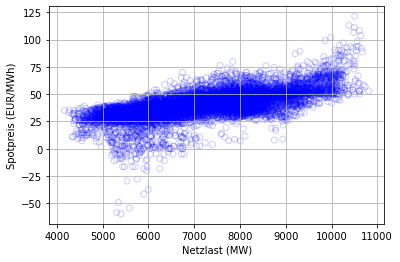

In [6]:
plt.scatter(demand, prices, alpha=0.2, facecolors='none', edgecolors='b')
plt.xlabel("Netzlast (MW)")
plt.ylabel("Spotpreis (EUR/MWh)")
plt.grid()

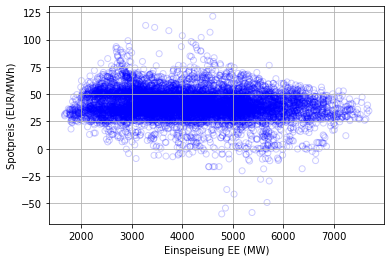

In [7]:
plt.scatter(generation_sum, prices, alpha=0.2, facecolors='none', edgecolors='b')
plt.xlabel("Einspeisung EE (MW)")
plt.ylabel("Spotpreis (EUR/MWh)")
plt.grid()

Aus den beiden Grafiken [6] und [7] kann bereits grob abgelesen werden, dass ein positiver Zusammenhang zwischen Netzlast und Spotpreis besteht und ein sehr leicht negativer Zusammenhang zwischen Einspeisung EE und Spotpreis. 

a) Das Regressionsmodell wurde folgendermaßen formuliert:
$$p_t = b_0 + b_1 * NL_t + b_2 * EE_t  $$
Mit:
$$p_t = Spotpreis\:  (EUR/MWh)\:  zum \: Zeitpunkt\:  t$$
$$NL_t = Netzlast \: zum \: Zeitpunkt\:  t$$
$$EE_t = Einspeisung\:  erneuerbarer\:  Energie\:  zum\:  Zeitpunkt\:  t$$

In [8]:
X = np.column_stack((demand, generation_sum))
y = prices

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     3921.
Date:                Thu, 22 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:44:31   Log-Likelihood:                -32160.
No. Observations:                8760   AIC:                         6.433e+04
Df Residuals:                    8757   BIC:                         6.435e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3092      0.643      2.035      0.0

b) Es wurde die Methode der kleinsten Quadrate (OLS) zur Schätzung der Koeffizienten verwendet. 
Die Ergebnisse der Regression sind die folgenden:

geschätzte Koeffizienten:
$$b_0 = 1.3092$$
$$b_1 = 0.0064 $$
$$b_2 = -0.0017$$

t-Statistiken: 2.035, -20.490, 86.183

adjustierte Bestimmtheitsmaß (R-squared): 0.472


Da die Beträge der t-Statistik größer als 1,96 sind, kann abgleitet werden, dass sich der jeweilige geschätzte Parameter mit 95% Wahrscheinlichkeit von 0 unterscheidet. 
Das adjustierte Bestimmtheitsmaß beträgt allerdings nur 0.427. Somit werden nur 42.7% der Varianz des Spotpreises in diesem Modell erfasst. 


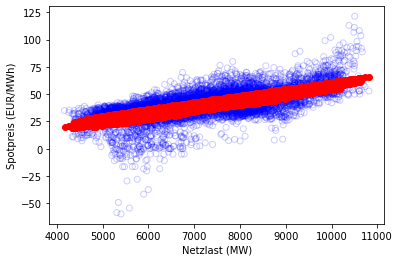

In [9]:

X = pd.DataFrame(pd.concat([df_demand_hourly["Demand"], df_generation_sum], axis=1))
Y = pd.DataFrame(df_prices['Price'])
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(demand, prices, alpha=0.2, facecolors='none', edgecolors='b')
plt.plot(pd.DataFrame(df_demand_hourly["Demand"]), Y_pred, 'o', color='red')
plt.xlabel("Netzlast (MW)")
plt.ylabel("Spotpreis (EUR/MWh)")
plt.show()


c) Grafik [9] zeigt den Zusammenhang zwischen Netzlast und Strompreis im Modell (rot) und mit tatsächlichen Strompreisen (blau). 
Es kann eine positive Korrelation zwischen Spotpreis und Netzlast in der Grafik sowie auch in der Regressionsanalyse (Koeffizient 0.0064) gezeigt werden. Dies entspricht ebenfalls der Realität, da basierend auf der Merit-Order-Kurve bei einer höheren Netzlast Spitzenlastkraftwerke mit höheren Grenzkosten zugeschaltet werden und diese somit einen höheren Preis festsetzen. 

d) Der Zusammenhang zwischen Einspeisung EE und Strompreis wurde mit dem Koeffizienten -0.0017 bestimmt. Diese negative Korrelation entsteht dadurch, dass die Grenzkosten von erneuerbaren Energieträgern bei 0 sind und sich somit bei einer höheren Einspeisung von EE der Preis reduziert, da Kraftwerke mit höheren Grenzkosten dann nicht benötigt werden. 